In [1]:
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms as T
import torch

c:\Users\Zhu Peiwen\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Img preprocessing

In [2]:
image_paths = sorted([str(p) for p in glob('img_align_celeba' + '/*.jpg')])
print(image_paths.__len__())

# 定义数据预处理的transforms
image_size = 128

# 数据预处理的transforms，将图像大小调整为image_size，并进行标准化
transforms = T.Compose([
    T.Resize((image_size, image_size), Image.BICUBIC),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # to scale [-1,1] with tanh activation
])

inverse_transforms = T.Compose([
    T.Normalize(-1, 2),
    T.ToPILImage()
])

# 划分训练集、验证集和测试集
train, valid = train_test_split(image_paths, test_size=5000, shuffle=True, random_state=42)
valid, test = train_test_split(valid, test_size=1000, shuffle=True, random_state=42)

# 输出数据集长度
print(f'Train size: {len(train)}, validation size: {len(valid)}, test size: {len(test)}.')

202599
Train size: 197599, validation size: 4000, test size: 1000.


## Configuration

In [3]:
epochs = 30
batch_size = 16
lr = 8e-5
mask_size = 64
path = r'painting_model.pth'
b1 = 0.5
b2 = 0.999
patch_h, patch_w = int(mask_size / 2 ** 3), int(mask_size / 2 ** 3)
patch = (1, patch_h, patch_w)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
## cuda信息
torch.cuda.is_available()

True

## Data Loader

In [4]:
from torch.utils.data import DataLoader, Dataset
import numpy as np

class CelebaDataset(Dataset):
    def __init__(self, images_paths, transforms=transforms, train=True):
        self.images_paths = images_paths
        self.transforms = transforms
        self.train = train
        
    def __len__(self):
        return len(self.images_paths)
    
    def apply_center_mask(self, image):
        # 将mask应用于图像的中心部分//遮挡中心部分
        idx = (image_size - mask_size) // 2
        masked_image = image.clone()
        masked_image[:, idx:idx+mask_size, idx:idx+mask_size] = 1
        masked_part = image[:, idx:idx+mask_size, idx:idx+mask_size]
        return masked_image, idx
    
    def apply_random_mask(self, image):
        # 将mask随机应用于图像的某个区域
        y1, x1 = np.random.randint(0, image_size-mask_size, 2)
        y2, x2 = y1 + mask_size, x1 + mask_size
        masked_part = image[:, y1:y2, x1:x2]
        masked_image = image.clone()
        masked_image[:, y1:y2, x1:x2] = 1
        return masked_image, masked_part
    
    def __getitem__(self, ix):
        path = self.images_paths[ix]
        image = Image.open(path)
        image = self.transforms(image)
        
        if self.train:
            masked_image, masked_part = self.apply_random_mask(image)
        else:
            masked_image, masked_part = self.apply_center_mask(image)
            
        return image, masked_image, masked_part
    
    def collate_fn(self, batch):
        images, masked_images, masked_parts = list(zip(*batch))
        images, masked_images, masked_parts = [[tensor.to(device) for tensor in tensors] for tensors in [images, masked_images, masked_parts]]
        #images, masked_images, masked_parts = [torch.cat(ims) for ims in [images, masked_images, masked_parts]]
        images= torch.cat(images).view(batch_size, -1, image_size, image_size)
        masked_images = torch.cat(masked_images).view(batch_size, -1, image_size, image_size)
        masked_parts = torch.cat(masked_parts).view(batch_size, -1, mask_size, mask_size)
        return images, masked_images, masked_parts
        
 # 创建数据集和数据加载器
train_dataset = CelebaDataset(train)
valid_dataset = CelebaDataset(valid, train=True)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=valid_dataset.collate_fn, drop_last=True)

## Network

# 定义初始化函数

In [5]:
import torch.nn as nn

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0, 0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1, 0.02)
        nn.init.zeros_(m.bias)


def set_params(model, unfreeze):
    for param in model.parameters():
        param.requires_grad = unfreeze

#定义生成器网络

In [6]:
class ResDown(nn.Module):
    def __init__(self, channel_in, channel_out, scale=2):
        super(ResDown, self).__init__()
        self.conv1 = nn.Conv2d(channel_in, channel_out//2, 3, 1, 1)
        self.batch_norm1 = nn.BatchNorm2d(channel_out//2, 0.8)
        self.conv2 = nn.Conv2d(channel_out//2, channel_out, 3, scale, 1)
        self.batch_norm2 = nn.BatchNorm2d(channel_out, 0.8)

        self.conv3 = nn.Conv2d(channel_in, channel_out, 3, scale, 1)
        self.activation = nn.LeakyReLU(0.2)  # 激活层

    def forward(self, x):
        skip = self.conv3(x)

        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.activation(x + skip)

        return x


class ResUp(nn.Module):
    def __init__(self, channel_in, channel_out, scale=2):
        super(ResUp, self).__init__()
        self.conv1 = nn.Conv2d(channel_in, channel_out//2, 3, 1, 1)
        self.batch_norm1 = nn.BatchNorm2d(channel_out//2, 0.8)
        self.conv2 = nn.Conv2d(channel_out//2, channel_out, 3, 1, 1)
        self.batch_norm2 = nn.BatchNorm2d(channel_out, 0.8)

        self.upscale = nn.Upsample(scale_factor=scale, mode="nearest")  # 上采样层
        self.conv3 = nn.Conv2d(channel_in, channel_out, 3, 1, 1)

        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        skip = self.conv3(self.upscale(x))

        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)

        x = self.conv2(self.upscale(x))
        x = self.batch_norm2(x)

        x = self.activation(x + skip)

        return x

# Encoder and Decoder

In [7]:
class Encoder(nn.Module):  # 编码器

    def __init__(self, channels, ch=64, z=512):
        super(Encoder, self).__init__()
        self.conv1 = ResDown(channels, ch)
        self.conv2 = ResDown(ch, 2*ch)
        self.conv3 = ResDown(2*ch, 4*ch)
        self.conv4 = ResDown(4*ch, 8*ch)
        self.conv5 = ResDown(8*ch, 8*ch)
        self.conv_mu = nn.Conv2d(8*ch, z, 2, 2)  # 卷积层
        self.conv_log_var = nn.Conv2d(8*ch, z, 2, 2)

    def sample(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        mu = self.conv_mu(x)
        log_var = self.conv_log_var(x)
        x = self.sample(mu, log_var)

        return x, mu, log_var


class Decoder(nn.Module):  # 解码器

    def __init__(self, channels, ch=64, z=512):
        super(Decoder, self).__init__()
        self.conv1 = ResUp(z, ch*8)
        self.conv2 = ResUp(ch*8, ch*4)
        self.conv3 = ResUp(ch*4, ch*2)
        self.conv4 = ResUp(ch*2, ch)
        self.conv5 = ResUp(ch, ch//2)
        self.conv6 = nn.Conv2d(ch//2, channels, 3, 1, 1)  # 卷积池
        self.activation = nn.Tanh()

    def forward(self, x):  # 传播的是解码器解码后的特征图
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)

        return self.activation(x)

# 生成器

In [8]:
class ResnetGenerator(nn.Module):
    def __init__(self, channel_in=3, ch=64, z=512):
        super(ResnetGenerator, self).__init__()

        self.encoder = Encoder(channel_in, ch=ch, z=z)
        self.decoder = Decoder(channel_in, ch=ch, z=z)

    def forward(self, x):  # 传播编码器编码后的特征向量
        encoding, mu, log_var = self.encoder(x)
        recon = self.decoder(encoding)
        return recon, mu, log_var

# 判别器


In [9]:
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize, dropout, spectral):
            if spectral:  # 封装稳定训练
                layers = [nn.utils.spectral_norm(
                    nn.Conv2d(in_filters, out_filters, 3, stride, 1), n_power_iterations=2)]
            else:
                layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:  # 归一化
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if dropout:  # 防止过拟合
                layers.append(nn.Dropout(p=0.5))
            return layers

        layers = []
        in_filters = channels
        for out_filters, stride, normalize, dropout, spectral in [(64, 2, False, 0, 0), (128, 2, True, 0, 0), (256, 2, True, 0, 0), (512, 1, True, 0, 0)]:
            layers.extend(discriminator_block(
                in_filters, out_filters, stride, normalize, dropout, spectral))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [10]:
from torchsummary import summary

generator = ResnetGenerator().apply(init_weights).to(device) 
summary(generator, (3, 128, 128)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
            Conv2d-2         [-1, 32, 128, 128]             896
       BatchNorm2d-3         [-1, 32, 128, 128]              64
         LeakyReLU-4         [-1, 32, 128, 128]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
         LeakyReLU-7           [-1, 64, 64, 64]               0
           ResDown-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
           Conv2d-10           [-1, 64, 64, 64]          36,928
      BatchNorm2d-11           [-1, 64, 64, 64]             128
        LeakyReLU-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,856
      BatchNorm2d-14          [-1, 128,

In [11]:
discriminator = Discriminator().apply(init_weights).to(device)
summary(discriminator, (3, 64, 64)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]          73,856
    InstanceNorm2d-4          [-1, 128, 16, 16]               0
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         295,168
    InstanceNorm2d-7            [-1, 256, 8, 8]               0
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 8, 8]       1,180,160
   InstanceNorm2d-10            [-1, 512, 8, 8]               0
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12              [-1, 1, 8, 8]           4,609
Total params: 1,555,585
Trainable params: 1,555,585
Non-trainable params: 0
---------------------------

# 定义对抗损失函数和优化器

In [12]:
class KLDLoss(nn.Module):
    def forward(self, mu, logvar, beta=1.0):
        kld = -0.5 * torch.sum(1 + logvar -
                               torch.pow(mu, 2) - torch.exp(logvar))
        return beta * kld


reconstruction_loss = nn.functional.mse_loss
kld_loss = KLDLoss()


def kld_criterion(x, y, mu, logvar): 
    #return reconstruction_loss(
    #y, x, reduction="sum") + kld_loss(mu, logvar, beta=0.1)
    a = reconstruction_loss(y, x, reduction='sum')
    b = kld_loss(mu, logvar, beta = 0.1)
    return a + b

adversarial_loss = nn.MSELoss()  # 对抗损失，使用均方误差损失代替二进制交叉熵损失

# 优化器
optimizer_G = torch.optim.Adam(
    generator.parameters(), lr=lr, betas=(b1, b2))  # 生成器优化器
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2))  # 判别器优化器

# Train model

In [13]:
def train_one_batch(batch, generator, discriminator, criterion_adv, criterion_pix, optimizer_G, optimizer_D):
    generator.train()
    discriminator.train()
    
    images, masked_images, masked_parts = batch
    real = torch.FloatTensor(batch_size, *patch).fill_(1.0).requires_grad_(False).to(device)  # 真实样本标签
    fake = torch.FloatTensor(batch_size, *patch).fill_(0.0).requires_grad_(False).to(device)  # 生成样本标签
    
    set_params(discriminator, False) 
    optimizer_G.zero_grad() 
    gen_parts, mu, logvar = generator(masked_images) 
    
    gan_loss = criterion_adv(discriminator(gen_parts), real) 
    pix_loss = criterion_pix(masked_parts, gen_parts, mu, logvar) 
    
    loss_g = 0.001 * gan_loss + 0.999 * pix_loss 
    loss_g.backward() 
    optimizer_G.step() 
    
    set_params(discriminator, True) 
    optimizer_D.zero_grad() 

    real_loss = criterion_adv(discriminator(masked_parts), real) # 真实样本损失
    fake_loss = criterion_adv(discriminator(gen_parts.detach()), fake) # 生成样本损失
    
    loss_d = (real_loss + fake_loss) / 2  
    loss_d.backward()
    optimizer_D.step() 
    
    return loss_g.item(), loss_d.item()

# Validation model

In [14]:
def validate_one_batch(batch, generator, discriminator, criterion_adv, criterion_pix):
    generator.eval()
    discriminator.eval()
    
    images, masked_images, masked_parts = batch
    real = torch.FloatTensor(batch_size, *patch).fill_(1.0).requires_grad_(False).to(device) # 真实样本标签
    fake = torch.FloatTensor(batch_size, *patch).fill_(0.0).requires_grad_(False).to(device) # 生成样本标签
    
    gen_parts, mu, logvar = generator(masked_images)
    
    gan_loss = criterion_adv(discriminator(gen_parts), real)
    pix_loss = criterion_pix(masked_parts, gen_parts, mu, logvar) 
    
    loss_g = 0.001 * gan_loss + 0.999 * pix_loss
    
    real_loss = criterion_adv(discriminator(masked_parts), real)
    fake_loss = criterion_adv(discriminator(gen_parts.detach()), fake)
    
    loss_d = (real_loss + fake_loss) / 2 
    return loss_g, loss_d
     

import matplotlib.pyplot as plt

@torch.no_grad()
def test_plot(test, generator, scale=1):
    idx = np.random.randint(len(test))
    random_path = test[idx]
    
    image = Image.open(random_path)
    image = transforms(image)
    
    masked_image, idx = train_dataset.apply_center_mask(image)
    
    generator.eval()
    gen_part = generator(masked_image.unsqueeze(0).to(device))[0].squeeze(0).cpu().detach()
    gen_image = masked_image.clone()
    gen_image[:, idx:idx+mask_size, idx:idx+mask_size] = gen_part
    
    # scale [-1,1] or [0,1]
    if scale:
        run_transforms = inverse_transforms
    else:
        run_transforms = T.ToPILImage()
    image = run_transforms(image)
    masked_image = run_transforms(masked_image)
    gen_image = run_transforms(gen_image)
    
    #生成对比图片
    plt.figure(figsize=(10, 5))
    plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(image)
    
    plt.subplot(132)
    plt.title('Masked Image')
    plt.imshow(masked_image)
    
    plt.subplot(133)
    plt.title('Inpainted Image')
    plt.imshow(gen_image)
    
    plt.tight_layout()
    plt.show()
    plt.pause(0.01)

# Training

In [ ]:
from tqdm import tqdm
#初始化损失
train_d_losses, valid_d_losses = [], []
train_g_losses, valid_g_losses = [], []
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    
    # 训练集迭代
    tq_bar = tqdm(train_dataloader, total=len(train_dataloader), desc=f'Train step {epoch+1}')
    epoch_d_losses, epoch_g_losses = [], []
    for _, batch in enumerate(tq_bar):
        g_loss, d_loss = train_one_batch(batch, generator, discriminator, adversarial_loss, 
                                         kld_criterion, optimizer_G, optimizer_D)
        epoch_g_losses.append(g_loss)
        epoch_d_losses.append(d_loss)
        tq_bar.set_postfix(g_loss=np.mean(epoch_g_losses), d_loss=np.mean(epoch_d_losses))
    
    train_d_losses.append(np.mean(epoch_d_losses))
    train_g_losses.append(np.mean(epoch_g_losses))
    # 验证集迭代
    tq_bar = tqdm(valid_dataloader, total=len(valid_dataloader), desc=f'Validation step {epoch+1}')
    epoch_d_losses, epoch_g_losses = [], []
    for _, batch in enumerate(tq_bar):
        g_loss, d_loss = validate_one_batch(batch, generator, discriminator, adversarial_loss, kld_criterion)
        epoch_d_losses.append(d_loss.detach().cpu().numpy())
        epoch_g_losses.append(g_loss.detach().cpu().numpy())
        tq_bar.set_postfix(g_loss=np.mean(epoch_g_losses), d_loss=np.mean(epoch_d_losses))

    valid_d_losses.append(np.mean(epoch_d_losses))
    valid_g_losses.append(np.mean(epoch_g_losses))
    
    if (epoch+1) % 2 == 0 or (epoch+1) == epochs:
        test_plot(test, generator)
        checkpoint = {
            'discriminator': discriminator,
            'generator': generator,
        }
        torch.save(checkpoint, path)
        

# Demo

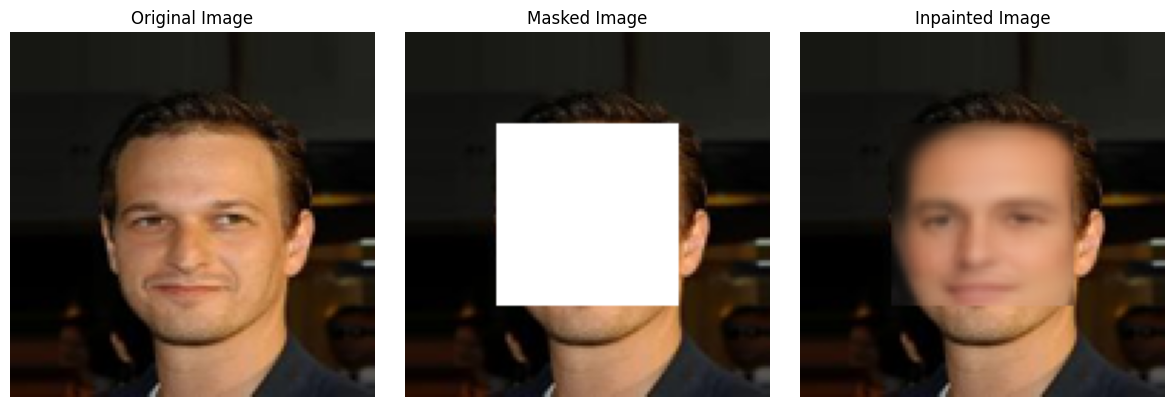

In [15]:

checkpoint = torch.load("painting_model.pth")
discriminator = checkpoint['discriminator']
generator = checkpoint['generator']

# 准备要修复的图像
image_path = "demo.jpg"
image = Image.open(image_path)
image = transforms(image)

# 对图像进行遮盖，生成待修复的图像
masked_image, idx = train_dataset.apply_center_mask(image)

# 使用生成器对遮盖后的图像进行修复
generator.eval()
with torch.no_grad():
    gen_part = generator(masked_image.unsqueeze(0).to(device))[0].squeeze(0).cpu().detach()
    gen_image = masked_image.clone()
    gen_image[:, idx:idx+mask_size, idx:idx+mask_size] = gen_part

# 将修复后的图像转换回原始格式
gen_image = inverse_transforms(gen_image)
masked_image = inverse_transforms(masked_image)
image = inverse_transforms(image)

# 显示原图、mask 图和输出图
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(masked_image)
plt.title("Masked Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(gen_image)
plt.title("Inpainted Image")
plt.axis("off")

plt.tight_layout()
plt.show()

# Result

Average Reconstruction Loss: 749.5078771758941


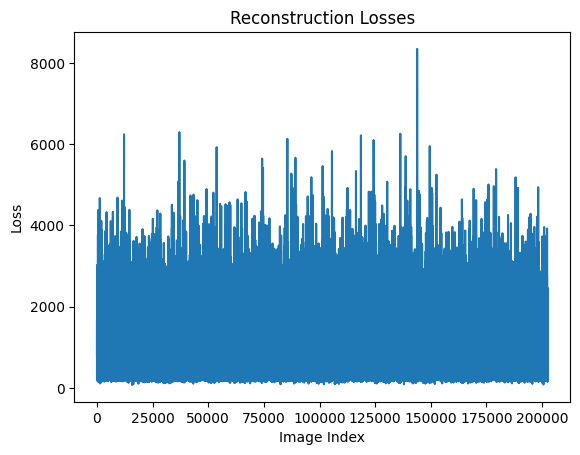

In [30]:
image_paths = sorted([str(p) for p in glob('img_align_celeba' + '/*.jpg')])
losses = []

for image_path in image_paths:
    image = Image.open(image_path)
    image = transforms(image)
    masked_image, idx = train_dataset.apply_center_mask(image)
    generator.eval()
    with torch.no_grad():
        gen_part = generator(masked_image.unsqueeze(0).to(device))[0].squeeze(0).cpu().detach()
        gen_image = masked_image.clone()
        gen_image[:, idx:idx+mask_size, idx:idx+mask_size] = gen_part
    loss = reconstruction_loss(gen_image, image, reduction='sum').item()
    losses.append(loss)

# calculate the avg of losses
avg_loss = np.mean(losses)
print(f'Average Reconstruction Loss: {avg_loss}')

plt.figure()
plt.plot(losses)
plt.title('Reconstruction Losses')
plt.xlabel('Image Index')
plt.ylabel('Loss')
plt.show()
    



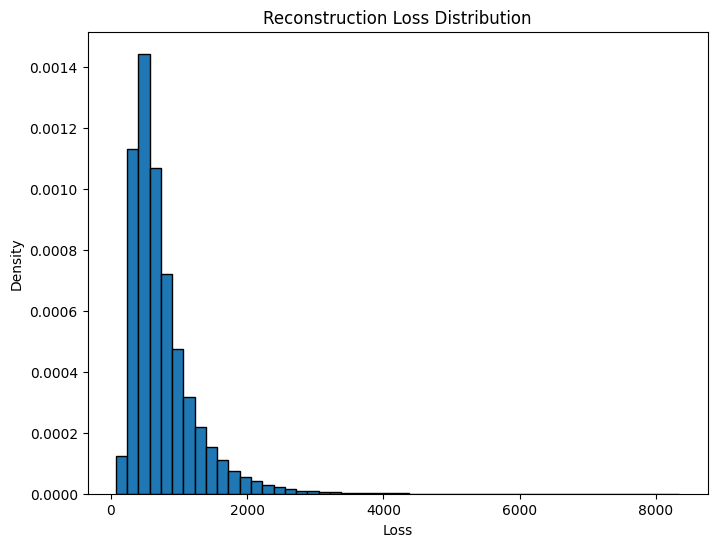

In [31]:
plt.figure(figsize=(8, 6))
plt.hist(losses, bins=50, density=True, edgecolor='black')
plt.title('Reconstruction Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.show()